# Core Features: Import

In [50]:
# libraries
import copy
import sys
import os
from typing import List
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

import torch
import torch.nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchinfo import summary
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = [18, 12]
%matplotlib inline

In [6]:
# code from this library - import the lines module
import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper, wrap_model
from loss_landscapes.model_interface.model_parameters import ModelParameters, rand_u_like, rand_n_like, orthogonal_to
from loss_landscapes.contrib.functions import SimpleWarmupCaller, SimpleLossEvalCaller, log_refined_loss

In [46]:
sys.path.append("/global/u2/g/geshi/PyHessian")
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot, density_generate # ESD plot

In [8]:
sys.path.append("/global/u2/g/geshi/Scientific_Segmentation/")
sys.path.append("/global/homes/g/geshi/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/cv2")
from pytorchUNetCRF.metrics import IOULoss, DiceLoss
from pytorchUNetCRF.models import SegmentationNet, CrfRnnNet
from pytorchUNetCRF.crfasrnn.params import DenseCRFParams
from pytorchUNetCRF.data_utils.input_pipeline import FiberSegDataset
from pytorchUNetCRF import test_UNet
from crfseg import CRF

Error in loading augmentation, can't import imgaug.Please make sure it is installed.


## 1. Preliminary: Define Parameters

In [9]:
# model architecture hyperparameters
downward_params = {
    'in_channels': 3, 
    'emb_sizes': [64, 128, 256, 512], 
    'kernel_sizes': [3, 3, 3 ,3 ,3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False,
}
upward_params = {
    'in_channels': [512, 1536, 768, 384, 192],
    'emb_sizes': [1024, 512, 256, 128, 64], 
    'out_channels': [1024, 512, 256, 128, 64],
    'kernel_sizes': [3, 3, 3, 3, 3], 
    'paddings': [1, 1, 1, 1, 1], 
    'batch_norm_first': False, 
    'bilinear': True,
}
output_params = {
    'in_channels': 64,
    'n_classes': 2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Hyper-parameters
train_images = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/train/img/"
train_annotations = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/train/ann/"
val_images = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/img/"
val_annotations = "/global/cfs/projectdirs/m636/Vis4ML/Fiber/Quarter/val/ann/"
batch_size=16
classes = ('background', 'foreground')
n_classes = len(classes)
n_workers = 0
input_height = 288
input_width = 288
output_height = 288
output_width = 288
other_inputs_paths=None
preprocessing=None
read_image_type=1

In [88]:
# contour plot resolution
STEPS = 20
RANDOM = 'normal'
NORM = 'layer'
DIST = 0.005
MODEL_DIR = '/global/cfs/cdirs/m636/geshi/exp/crf/CrossEntropy/0_seed_243'
trained_on = MODEL_DIR.split('/')[-2]
seed = (int)(MODEL_DIR.split('/')[-1].split('_')[-1])
use_hessian = True

In [20]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [33]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [34]:
dataset = FiberSegDataset(train_images, train_annotations, n_classes, 
    input_height, input_width, output_height, output_width,
    transform=data_transform, target_transform = target_transform,
    other_inputs_paths=other_inputs_paths, preprocessing=preprocessing, 
    read_image_type=read_image_type, ignore_segs=False)

val_dataset = FiberSegDataset(val_images, val_annotations, n_classes, 
    input_height, input_width, output_height, output_width,
    transform=data_transform, target_transform = target_transform,
    other_inputs_paths=other_inputs_paths, preprocessing=preprocessing, 
    read_image_type=read_image_type, ignore_segs=False)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

## 2. Model construction and evaluation

In [21]:
x = torch.rand(1, 3, 288, 288)
unet = SegmentationNet(downward_params, upward_params, output_params)
model = nn.Sequential(
    unet,
    CRF(n_spatial_dims=2)
)
out = model(x)
print('output shape', out.shape)

output shape torch.Size([1, 2, 288, 288])


In [22]:
model = model.to(device)
model.eval()
# stores the initial point in parameter space
model_initial = copy.deepcopy(model)

In [28]:
# define the comparison function to sort
def srotFunc(e):
    return int(e.split('-')[0].split('iter')[1])

In [31]:
# define settings to try
try_models = []
for name in os.listdir(MODEL_DIR):
    if name.endswith('.pt'):
        try_models.append(name)
try_models.sort(key=srotFunc, reverse=True)
print(try_models)

['iter4096-08-23-2023-02:19:49.pt', 'iter2048-08-23-2023-01:23:38.pt', 'iter1024-08-23-2023-00:54:04.pt', 'iter512-08-23-2023-00:40:28.pt', 'iter256-08-23-2023-00:34:24.pt', 'iter128-08-23-2023-00:32:42.pt', 'iter64-08-23-2023-00:31:50.pt', 'iter32-08-23-2023-00:31:21.pt', 'iter16-08-23-2023-00:31:09.pt', 'iter8-08-23-2023-00:31:00.pt', 'iter4-08-23-2023-00:30:57.pt', 'iter2-08-23-2023-00:30:55.pt', 'iter1-08-23-2023-00:30:53.pt', 'iter0-08-23-2023-00:30:46.pt']


In [107]:
checkpoint = torch.load(os.path.join(MODEL_DIR, try_models[0]), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
test_UNet(model, val_dataloader, classes, device)

Test : 100%|██████████| 157/157 [00:58<00:00,  2.68batch/s, accuracy=97.3]

Testing complete in 0m 59s, Test Acc: 97.297412109375, Test Iou: 0.9378663555579692


{'class_wise_IOU': array([0.96216685, 0.91356586]),
 'frequency_weighted_IOU': 0.9476994506962986,
 'mean_IOU': 0.9378663555579692}

In [36]:
criterion = torch.nn.CrossEntropyLoss() # DiceLoss(True), IOULoss(softmax=True)
model_final = copy.deepcopy(model)

In [37]:
x, y = iter(dataloader).__next__()
metric = loss_landscapes.metrics.Loss(criterion, x.to(device), y.to(device))

## 3. Hessianm Eigenvalue Spectrum Density

In [65]:
hessian_comp = hessian(model_final,
                       criterion,
                       data=(x.to(device), y.to(device)),
                       device=device)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

dir_one = ModelParameters(top_eigenvector[0])
dir_two = ModelParameters(top_eigenvector[1])

In [66]:
trace = hessian_comp.trace()
print("The trace of this model is: %.4f"%(np.mean(trace)))

The trace of this model is: 0.5530


In [67]:
density_eigen, density_weight = hessian_comp.density()

In [68]:
density, grids = density_generate(density_eigen, density_weight)

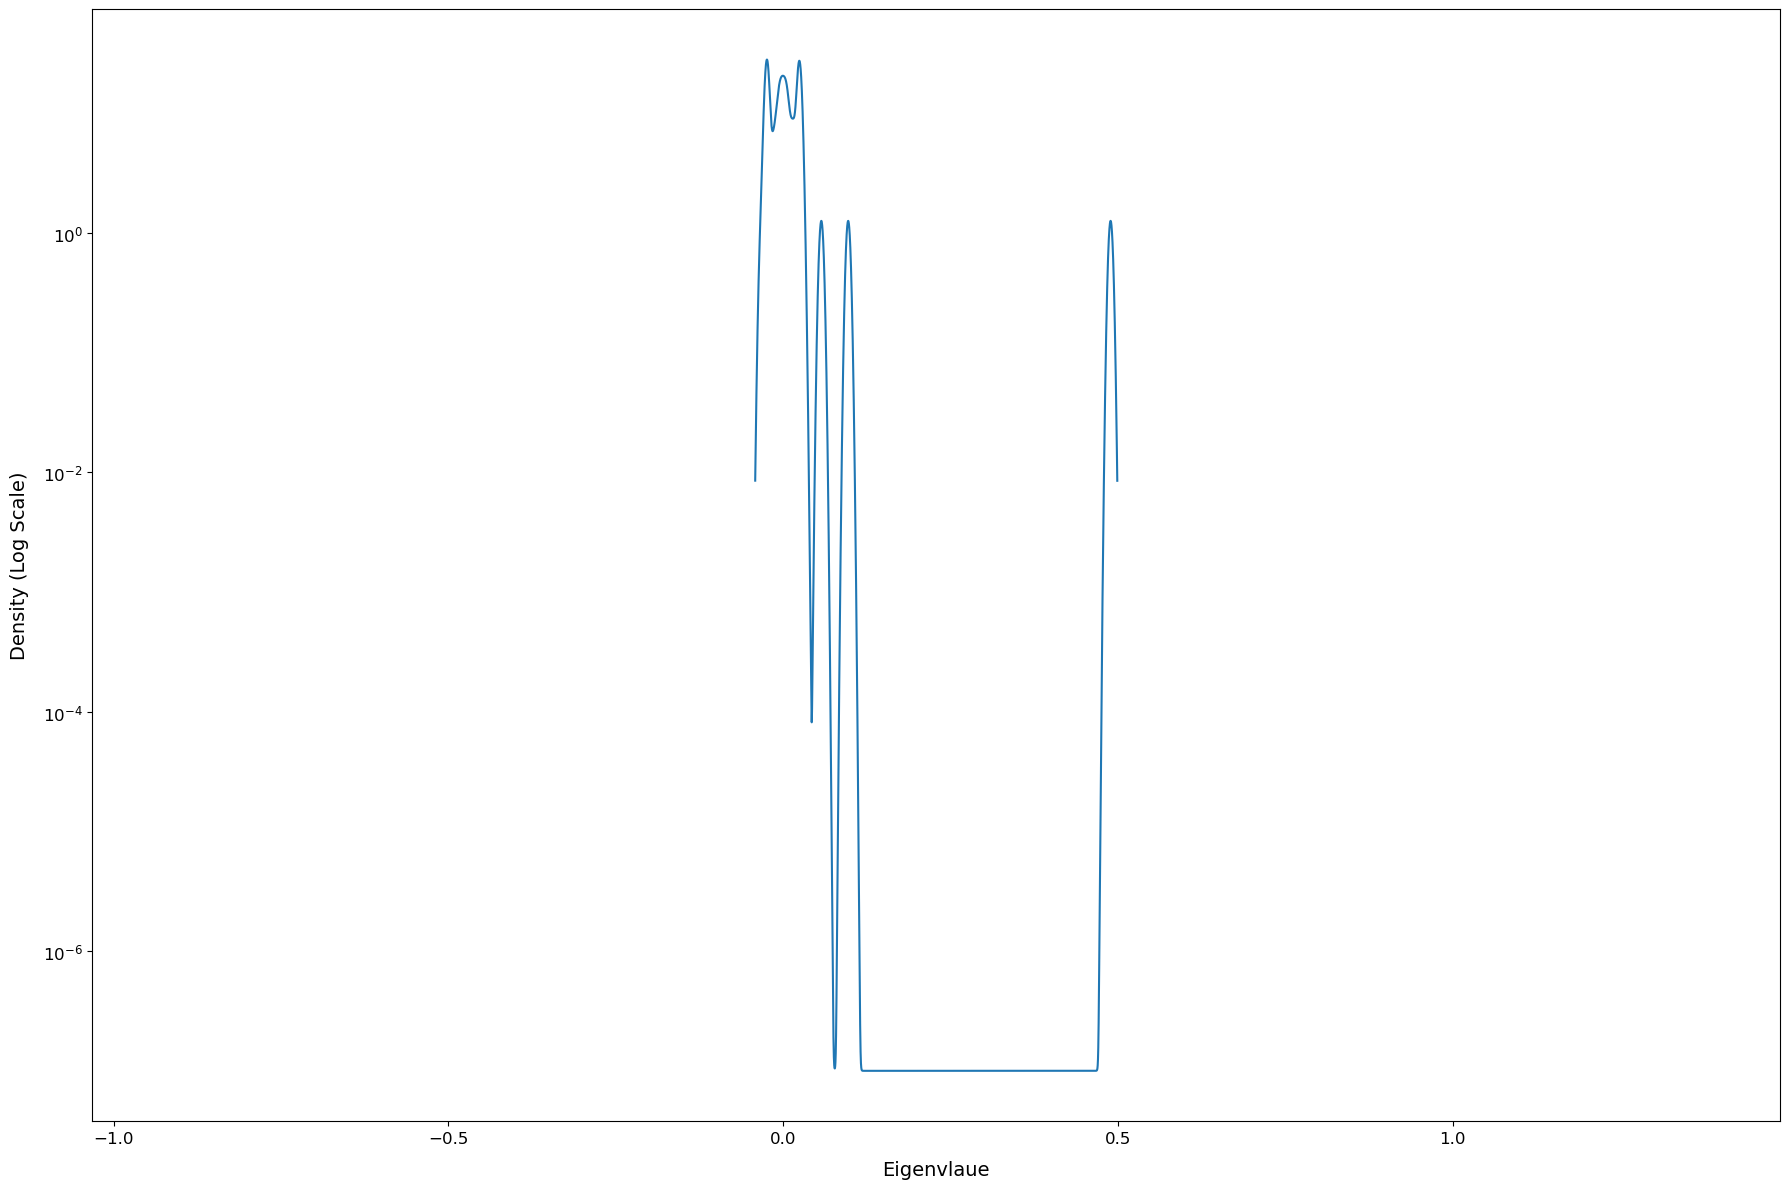

In [69]:
plt.semilogy(grids, density + 1.0e-7)
plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([np.min(density_eigen) - 1, np.max(density_eigen) + 1, None, None])
plt.tight_layout()
plt.show()

## 4. 2D Loss Landscape

In [70]:
def refined_loss(loss):
    return np.log(1.+loss)

In [89]:
# compute loss data
pll = loss_landscapes.PlanarLossLandscape(model_final, STEPS, deepcopy_model=True)
pll.precomputed(dir_one, dir_two, distance=DIST, normalization=NORM, centered=True)
pll.stats_initializer()

In [90]:
# single batch loss landscape
since = time.time()
pll.warm_up(metric)
print('warmup time cost ', time.time()-since)

since = time.time()
loss_data = pll.compute(metric)
print('compute time cost ', time.time()-since)

warmup time cost  36.03263783454895
compute time cost  33.68071722984314


In [91]:
loss_data_fin = refined_loss(loss_data)
loss_data_fin = loss_data

The loss values on this plane can be visualized in an intuitive and interpretable manner using contour plots or 3D surface plots:

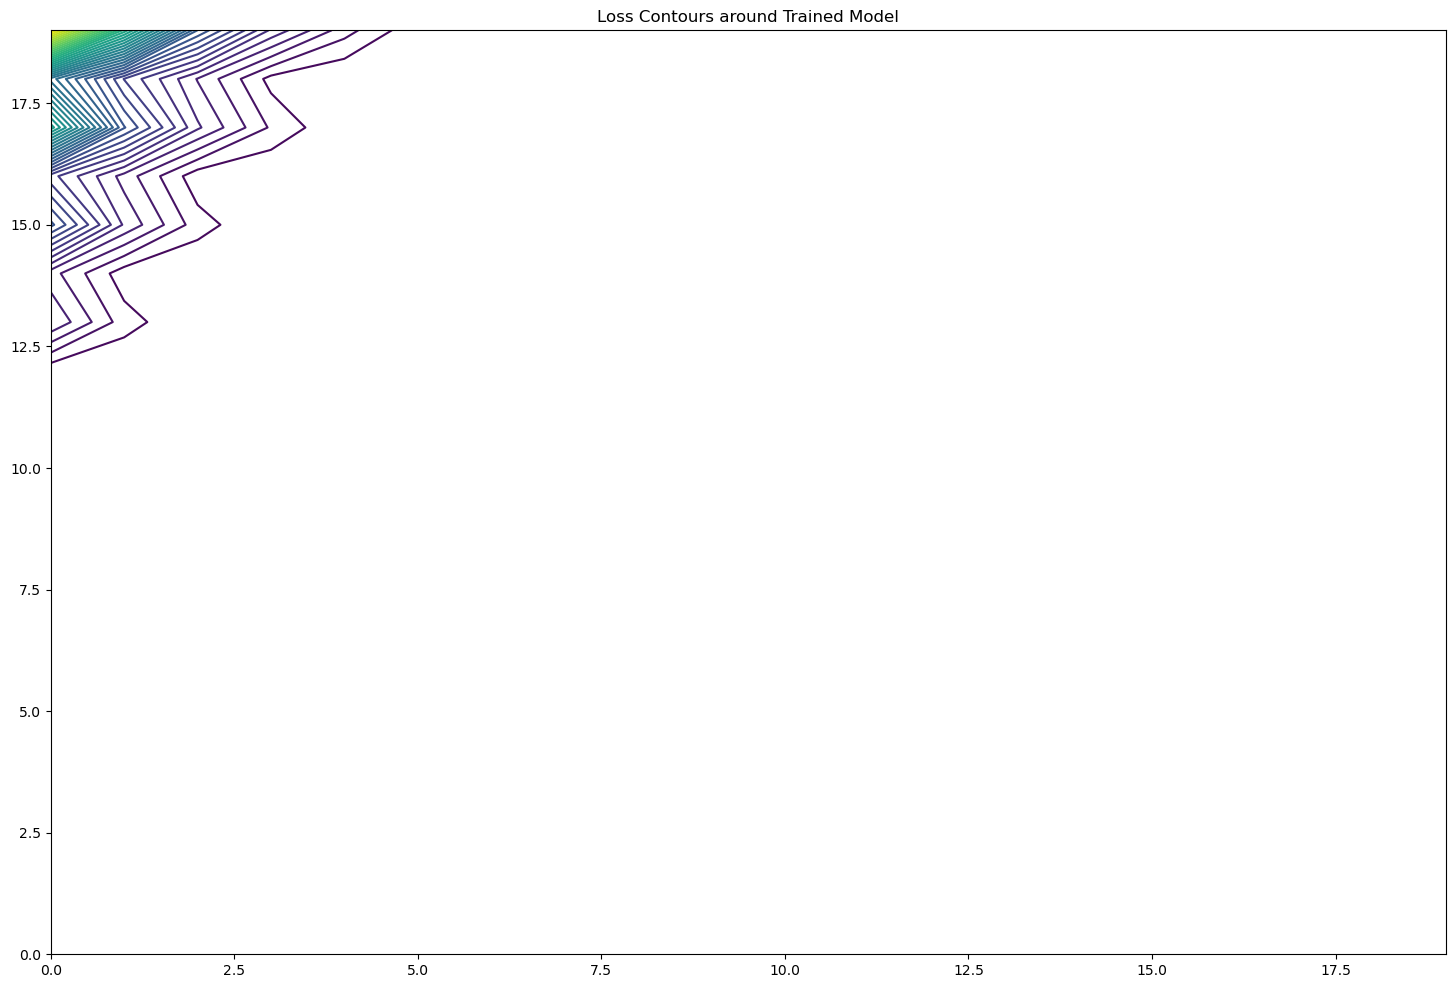

In [92]:
plt.contour(loss_data_fin, levels=50)
plt.title('Loss Contours around Trained Model')
plt.show()

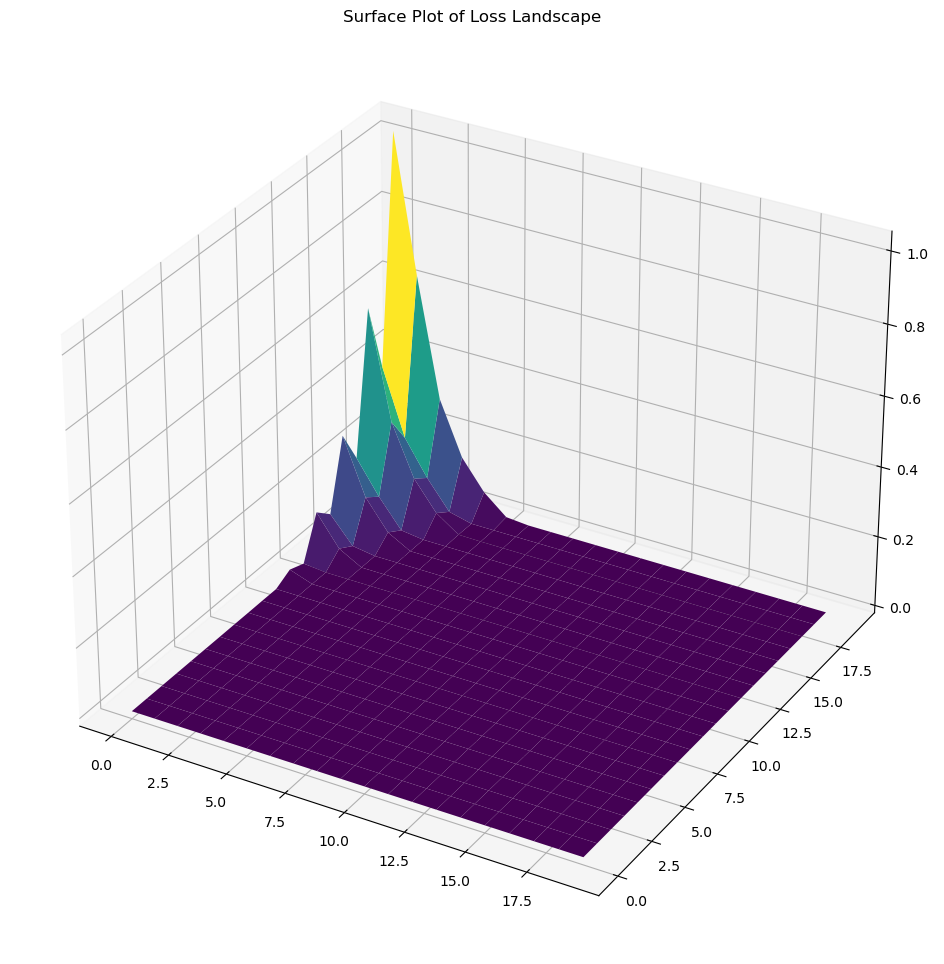

In [93]:
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Surface Plot of Loss Landscape')
fig.show()